# Dataworth with Freyberg Pilot Points Model

Here we are going to investigate the sources of forecast uncertainty as well as the worth of observations to reduce forecast uncertainty.  This is essentially the same workflow as used with the ``freyberg_zone_dataworth`` excersize.  Important things to remember:
- FOSM doesn't require values for observations, parameters or forecast.  We do need sensitivities between the quantities and estimates of prior uncertainties for parameters and observtion noise.  
- 

In [1]:
%matplotlib inline
import os
import sys
sys.path.append("..")
import shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import flopy
import pyemu

In [2]:
import freyberg_setup as fs
fs.setup_pest_pp()
working_dir = fs.WORKING_DIR_PP
pst_name = fs.PST_NAME_PP

['.DS_Store', 'botm.ref', 'extract_zone_array.py', 'forecasts_true.csv', 'freyberg.bas', 'freyberg.dbf', 'freyberg.dis', 'freyberg.hds', 'freyberg.heads', 'freyberg.heads_potobs.ins', 'freyberg.hyd', 'freyberg.list', 'freyberg.locations', 'freyberg.mpbas', 'freyberg.mpenpt', 'freyberg.mplist', 'freyberg.mpnam', 'freyberg.mppthln', 'freyberg.mpsim', 'freyberg.oc', 'freyberg.pcg', 'freyberg.rivflux', 'freyberg.shp', 'freyberg.shx', 'freyberg.travel', 'freyberg.truth.lpf', 'freyberg.truth.nam', 'freyberg.truth.rch', 'freyberg.truth.riv', 'freyberg.truth.wel', 'hk.truth.ref', 'hk.zones', 'ibound.ref', 'kzone.ref', 'mpath.in', 'obs_loc.csv', 'potobs_group.csv', 'Process_output.py', 'run_true_model.py', 'strt.ref', 'Weights_and_best_PHI.xlsx']

changing model workspace...
   freyberg_pp
FloPy is using the following executable to run the model: /Users/jwhite/Dev/GW1876/activities/freyberg_pilot_points_dataworth/freyberg_pp/mfnwt

                                  MODFLOW-NWT-SWR1 
    U.S. GE

In [33]:
pst = pyemu.Pst(os.path.join(working_dir,pst_name))
par = pst.parameter_data
par.loc[par.parnme.apply(lambda x: x.startswith("w")),"partrans"] = "fixed"
pst.control_data.noptmax = -1
pst.write(os.path.join(working_dir,pst_name))


In [34]:
os.chdir(working_dir)
pyemu.helpers.start_slaves('.',"pestpp",pst_name,num_slaves=15,master_dir=".")
os.chdir("..")

master:./pestpp freyberg_pp.pst /h :4004 in .
slave:./pestpp freyberg_pp.pst /h localhost:4004 in ../slave_0
slave:./pestpp freyberg_pp.pst /h localhost:4004 in ../slave_1
slave:./pestpp freyberg_pp.pst /h localhost:4004 in ../slave_2
slave:./pestpp freyberg_pp.pst /h localhost:4004 in ../slave_3
slave:./pestpp freyberg_pp.pst /h localhost:4004 in ../slave_4
slave:./pestpp freyberg_pp.pst /h localhost:4004 in ../slave_5
slave:./pestpp freyberg_pp.pst /h localhost:4004 in ../slave_6
slave:./pestpp freyberg_pp.pst /h localhost:4004 in ../slave_7
slave:./pestpp freyberg_pp.pst /h localhost:4004 in ../slave_8
slave:./pestpp freyberg_pp.pst /h localhost:4004 in ../slave_9
slave:./pestpp freyberg_pp.pst /h localhost:4004 in ../slave_10
slave:./pestpp freyberg_pp.pst /h localhost:4004 in ../slave_11
slave:./pestpp freyberg_pp.pst /h localhost:4004 in ../slave_12
slave:./pestpp freyberg_pp.pst /h localhost:4004 in ../slave_13
slave:./pestpp freyberg_pp.pst /h localhost:4004 in ../slave_14


In [35]:
sc = pyemu.Schur(os.path.join(working_dir,pst_name.replace(".pst",".jcb")))

A quick check of which parameters are being informed by the observations during calibration:

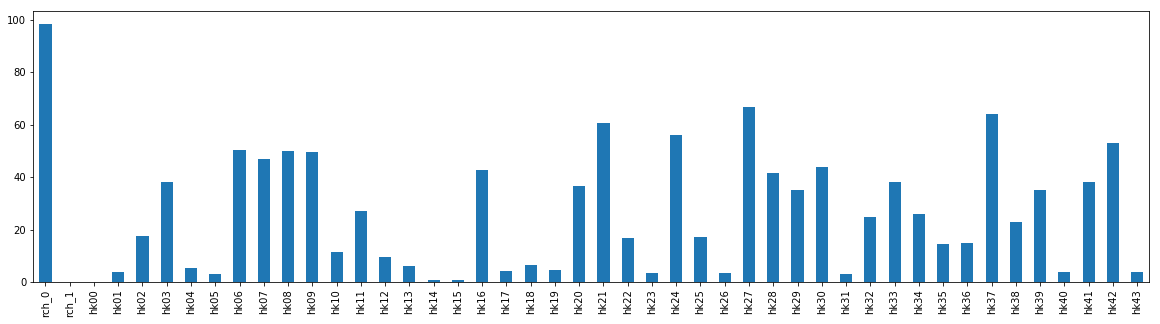

In [36]:
fig = plt.figure(figsize=(20,5))
ax = plt.subplot(111)
sc.get_parameter_summary().percent_reduction.plot(kind="bar",ax=ax)

## Parameter contribution analysis

We are going to use the ``Schur.get_par_contribution()`` method. It calculates the *decrease* in forecast uncertainty resulting for hypothetical "perfect knowledge" (no uncertainty) of arbitrary groups of parameters. If you don't pass any arguments, then it tests each parameter independently:

In [37]:
df_pc = sc.get_par_contribution()


In [38]:
df_pc = 100.0 * (1.0 - df_pc / df_pc.loc["base",:])

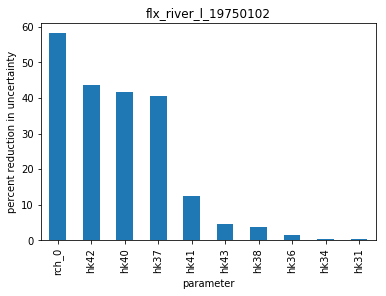

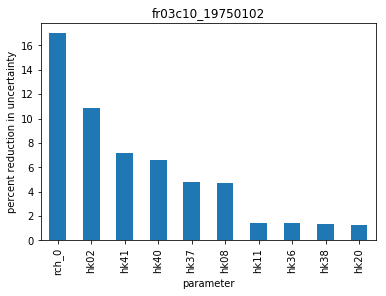

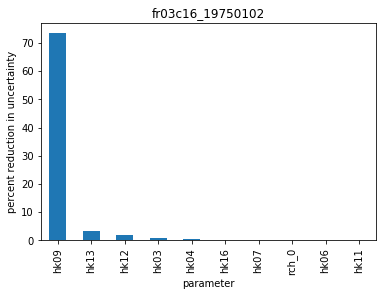

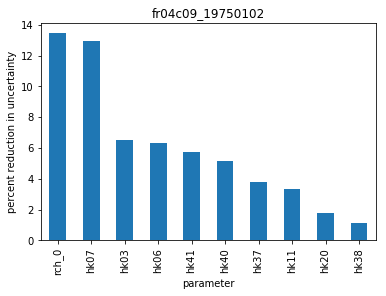

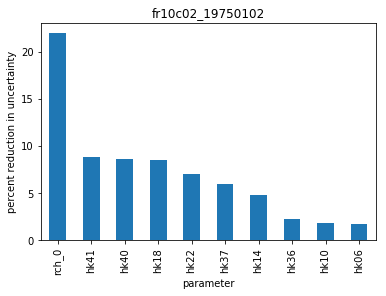

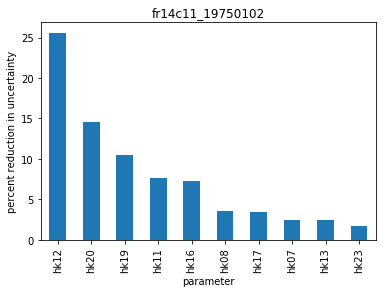

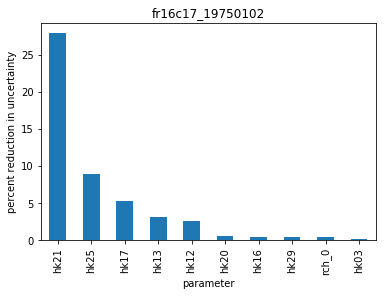

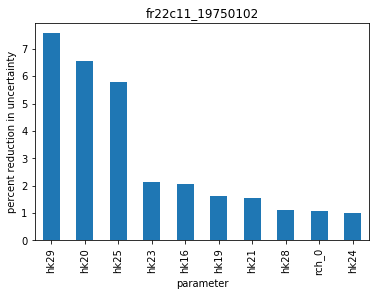

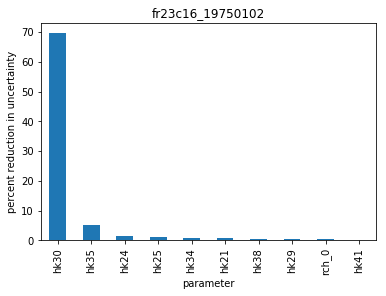

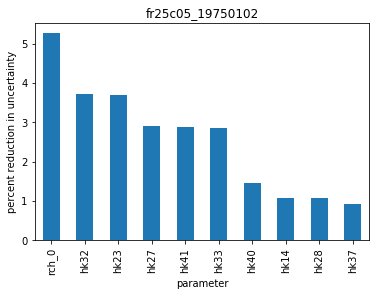

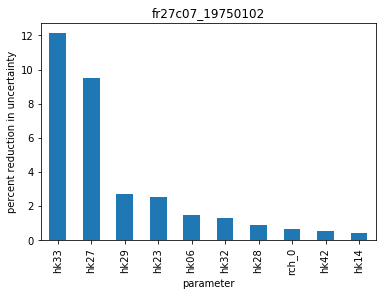

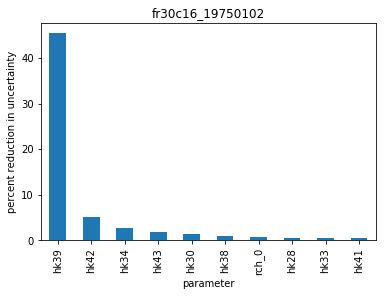

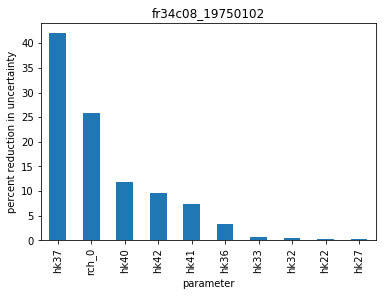

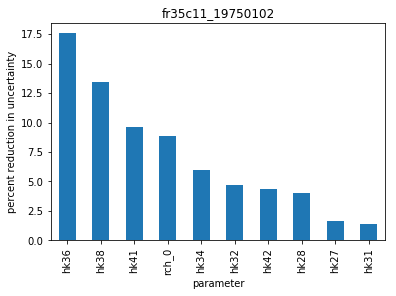

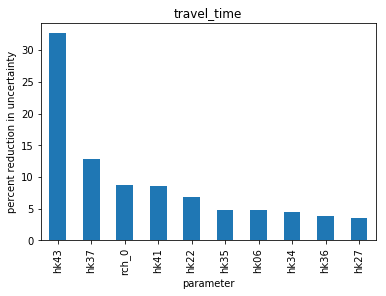

In [39]:
for forecast in df_pc.columns:
    ax = df_pc.sort_values(by=forecast,ascending=False).loc[:,forecast].iloc[:10].plot(kind="bar")
    ax.set_title(forecast)
    ax.set_ylabel("percent reduction in uncertainty")
    ax.set_xlabel("parameter")
    plt.show()

We see a mixture of HK pilot points, recharge, and well pumping rates...so we see that each forecast depends on (potentailly) difference combinations of parameters.  Does this mean we can still make a model that makes several kinds of forecasts???

## Observation worth

Let's see what observations are most important to the forecasts.  We will start be investigating the value of the existing observations using the ``Schur.get_removed_obs_importance()`` method.  It calculates the *increase* in forecast uncertainty that happens if we lose each existing observation. We will start with the existing observations:

In [40]:
df_rm = sc.get_removed_obs_importance()
df_rm

,flx_river_l_19750102,fr03c10_19750102,fr03c16_19750102,fr04c09_19750102,fr10c02_19750102,fr14c11_19750102,fr16c17_19750102,fr22c11_19750102,fr23c16_19750102,fr25c05_19750102,fr27c07_19750102,fr30c16_19750102,fr34c08_19750102,fr35c11_19750102,travel_time
base,1363.240291,0.017872,0.013678,0.029016,0.047671,0.034980,0.019228,0.018141,0.013528,0.032357,0.026747,0.014050,0.031126,0.030712,2.881629e+07
cr16c17_19700102,1363.423773,0.017872,0.013692,0.029031,0.047677,0.035063,0.092505,0.019509,0.013542,0.032378,0.026773,0.014063,0.031127,0.030720,2.883147e+07
cr03c10_19700102,1363.271887,0.093689,0.013702,0.029020,0.047865,0.035165,0.019233,0.018146,0.013528,0.032374,0.026766,0.014050,0.031130,0.030715,2.884221e+07
cr22c11_19700102,1366.737301,0.017874,0.013679,0.029030,0.047885,0.035354,0.019234,0.242436,0.014721,0.033840,0.027231,0.014058,0.031177,0.030782,3.050784e+07
cr14c11_19700102,1363.467135,0.018447,0.013698,0.030230,0.047951,0.221405,0.019349,0.019421,0.013568,0.032479,0.027038,0.014052,0.031139,0.030731,2.897367e+07
cr25c05_19700102,1363.952197,0.017876,0.013679,0.029071,0.048421,0.035137,0.019232,0.018225,0.013559,0.924565,0.027273,0.014059,0.031204,0.030725,2.967373e+07
cr30c16_19700102,1368.470053,0.018017,0.013679,0.029218,0.048024,0.034993,0.019230,0.018141,0.013834,0.032649,0.026911,0.038112,0.031154,0.030713,4.893817e+07
cr35c11_19700102,2599.842712,0.018772,0.013682,0.030162,0.052355,0.035149,0.019261,0.018623,0.013532,0.038404,0.033652,0.014491,0.040011,0.274613,4.765977e+07
cr10c02_19700102,1363.635604,0.018013,0.013684,0.031234,2.235717,0.035046,0.019229,0.018311,0.013528,0.032618,0.027352,0.014050,0.031129,0.030789,2.895548e+07
cr34c08_19700102,1637.936971,0.017921,0.013679,0.029066,0.048024,0.034987,0.019232,0.018152,0.013539,0.032432,0.026747,0.014059,0.577584,0.072270,2.964756e+07


In [41]:
df_rm = 100.0 * (1.0 - df_rm.loc["base",:] / df_rm)

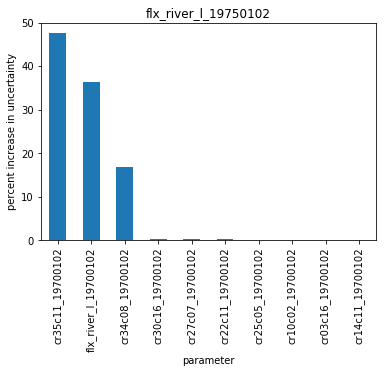

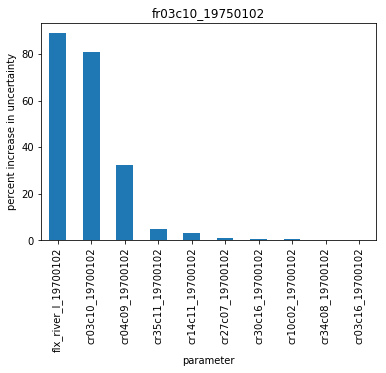

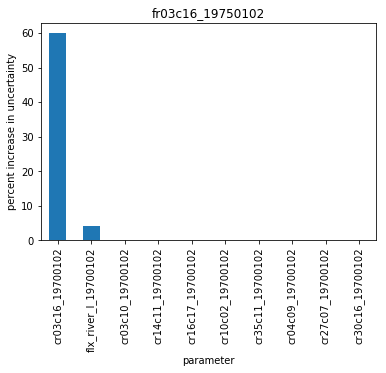

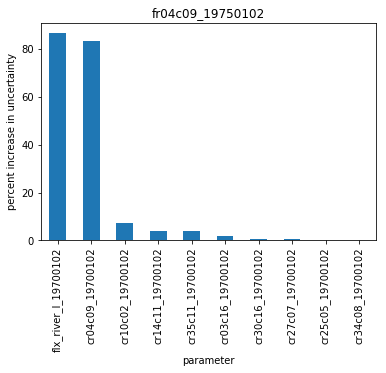

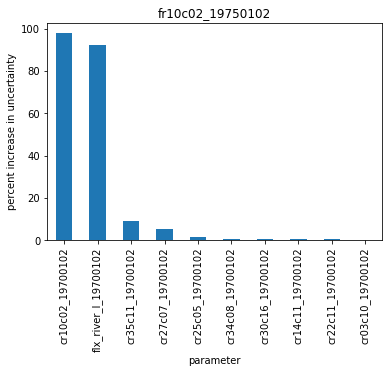

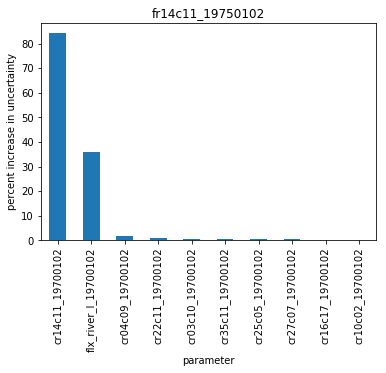

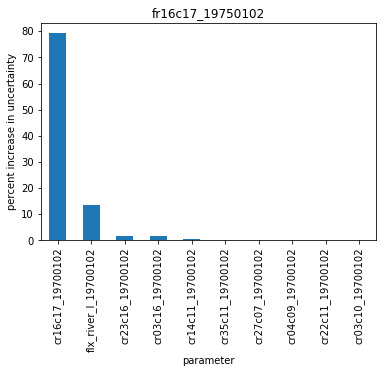

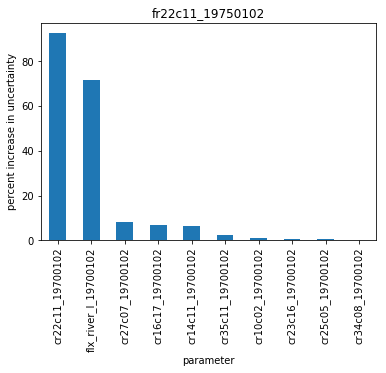

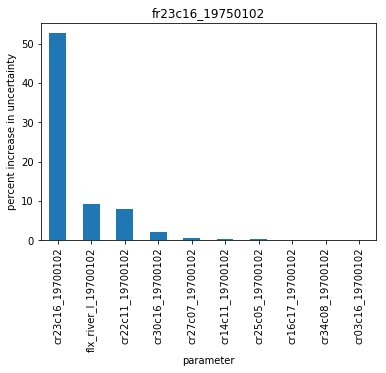

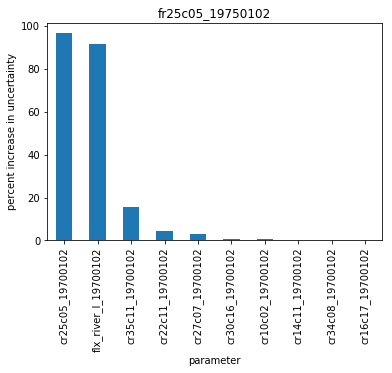

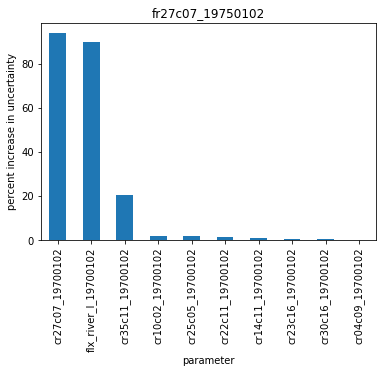

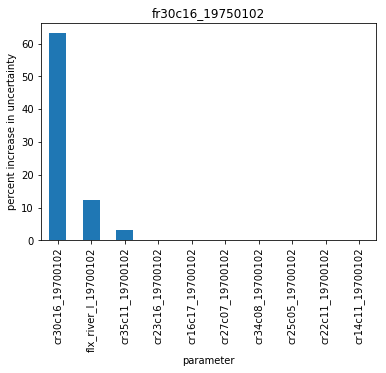

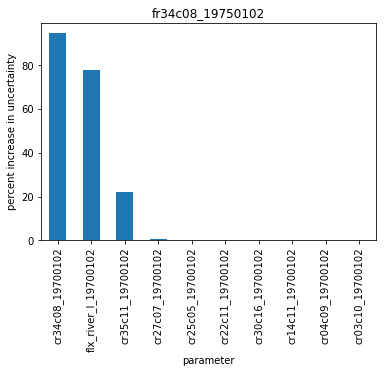

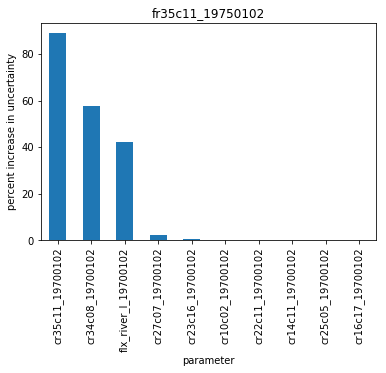

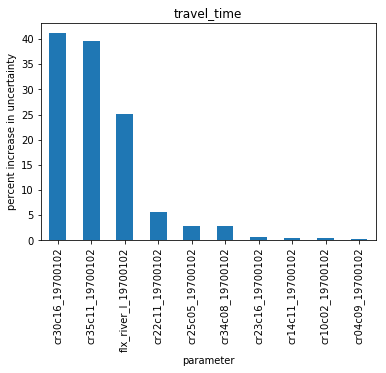

In [42]:
for forecast in df_rm.columns:
    ax = df_rm.sort_values(by=forecast,ascending=False).loc[:,forecast].iloc[:10].plot(kind="bar")
    ax.set_title(forecast)
    ax.set_ylabel("percent increase in uncertainty")
    ax.set_xlabel("parameter")
    plt.show()

### Estimating the value of yet-to-be-collected observations

Using the assumptions of FOSM, we can also calculate the value of observations we don't have yet!  Black magic!  Not really, we carried these possible data locations as ``observations`` in the control file - this means each one has a row in the jacobian (just like any other output of interest).  If we then assume some value of measurement noise (a non-zero weight in the control file), we can run a hypothetical "calibration" analysis using Schur compliment.  Remember, FOSM doesn't care about actual values of parameters, observations, or forecasts, only sensitivities...

In pyemu, the ``Schur.get_added_obs_importance()`` method calculates the *decrease* in uncertainty resulting for having new obsevations during calibration.  It accepts an optional argument ``obslist_dict`` which is a python dictionary of groups of new observations to test.  Here we will test the value of having the water level in each unmeasured model cell.  Then we can make maps of where to collect new data...these calculations take a little while to run because we are repeatedly calculating the entire FOSM process for each new observation location 

In [43]:
pobs_names = [o for o in sc.pst.obs_names if o.startswith("pr") and "19700102" in o]
df_ad = sc.get_added_obs_importance(obslist_dict={oname:oname for oname in pobs_names},
                                base_obslist=sc.pst.nnz_obs_names,reset_zero_weight=True)

In [44]:
df_ad.min()

flx_river_l_19750102    1.249886e+03
fr03c10_19750102        1.696754e-02
fr03c16_19750102        1.161416e-02
fr04c09_19750102        2.576771e-02
fr10c02_19750102        4.143713e-02
fr14c11_19750102        2.611208e-02
fr16c17_19750102        1.776243e-02
fr22c11_19750102        1.728064e-02
fr23c16_19750102        1.110643e-02
fr25c05_19750102        2.955174e-02
fr27c07_19750102        2.576094e-02
fr30c16_19750102        1.151837e-02
fr34c08_19750102        2.933819e-02
fr35c11_19750102        2.688659e-02
travel_time             2.382684e+07
dtype: float64

In [45]:
df_ad.max()

flx_river_l_19750102    1.363240e+03
fr03c10_19750102        1.787190e-02
fr03c16_19750102        1.367847e-02
fr04c09_19750102        2.901615e-02
fr10c02_19750102        4.767083e-02
fr14c11_19750102        3.498018e-02
fr16c17_19750102        1.922848e-02
fr22c11_19750102        1.814090e-02
fr23c16_19750102        1.352760e-02
fr25c05_19750102        3.235739e-02
fr27c07_19750102        2.674698e-02
fr30c16_19750102        1.405018e-02
fr34c08_19750102        3.112630e-02
fr35c11_19750102        3.071196e-02
travel_time             2.881629e+07
dtype: float64

In [46]:
# just a helper function to make maps of data worth
m = flopy.modflow.Modflow.load(fs.MODEL_NAM,model_ws=working_dir)
obs = pst.observation_data
hobs = obs.loc[obs.obgnme=="calhead",:].copy()
hobs.loc[:,"i"] = hobs.obsnme.apply(lambda x: int(x[2:4])-1)
hobs.loc[:,"j"] = hobs.obsnme.apply(lambda x: int(x.split('_')[0].split('c')[-1])-1)
hobs.loc[:,"x"] = m.sr.xcentergrid[hobs.i,hobs.j]
hobs.loc[:,"y"] = m.sr.ycentergrid[hobs.i,hobs.j]
wdata = pd.DataFrame.from_records(m.wel.stress_period_data[0])
wdata.loc[:,"x"] = m.sr.xcentergrid[wdata.i,wdata.j]
wdata.loc[:,"y"] = m.sr.ycentergrid[wdata.i,wdata.j]
pp_df = pyemu.pp_utils.pp_file_to_dataframe(os.path.join(working_dir,"hkpp.dat"))
def plot_added_worth(df):
    df_base = df.loc["base",:]
    df_frac = 100.0 * (1.0 - (df / df_base))
    df_frac = df_frac.loc[pobs_names,:]
    df_frac.loc[:,"i"] = df_frac.index.map(lambda x: int(x[2:4])-1)
    df_frac.loc[:,"j"] = df_frac.index.map(lambda x: int(x[5:7])-1)
    #print(df_frac.)
    for forecast in sc.pst.forecast_names:
        print(forecast)
        arr = np.zeros((m.nrow,m.ncol)) - 1
        arr[df_frac.i,df_frac.j] = df_frac.loc[:,forecast]
        arr = np.ma.masked_where(arr < 0.0 ,arr)
        fig = plt.figure(figsize=(12,10))
        
        ax = plt.subplot(111,aspect="equal")
        c = ax.pcolormesh(m.sr.xedge,m.sr.yedge,arr,alpha=0.75)
        plt.colorbar(c)
        if forecast.startswith("fr"):
            i = int(forecast[2:4]) - 1
            j = int(forecast.split('_')[0].split('c')[-1]) - 1
            x,y = m.sr.xcentergrid[i,j],m.sr.ycentergrid[i,j]
            ax.scatter([x],[y],marker='o',color='r',s=150)
            #ax2.scatter([x],[y],marker='o',color='r',s=150)    
        ax.scatter(hobs.x,hobs.y,marker='x',s=100,color='y')
        ax.scatter(wdata.x,wdata.y,marker='*',s=100,color='m')
        ax.scatter(pp_df.x,pp_df.y,marker='.',color='w',s=50)
        ax.set_title(forecast)
        
        plt.show()
        plt.close(fig)
    

Now we are going to plot the worth (reduction in uncertainty) of a single, new water level measurement for each forecast (forecast name is the title of each plot). So these plots show us where to go collect new data to reduce forecast uncertainty as much as possible...red circles show the forecast (for water level forecasts), yellow X's are the locations of existing water levels, purple stars mark pumping well locations (pumping rates are treated as uncertain!)

fr03c10_19750102


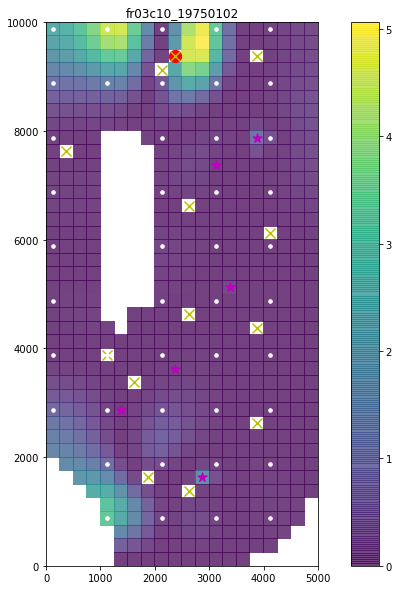

fr03c16_19750102


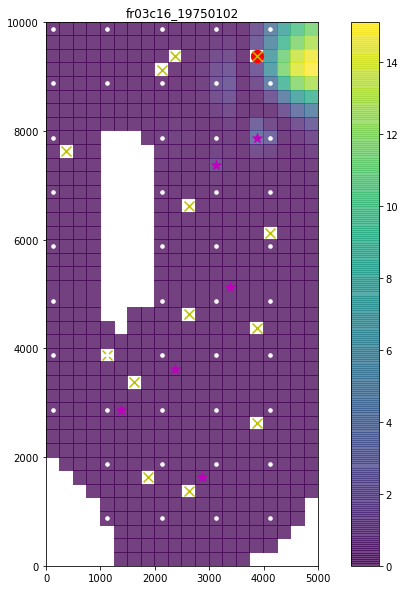

fr04c09_19750102


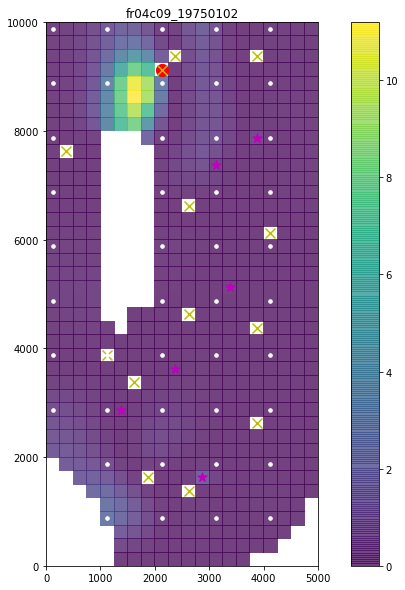

fr10c02_19750102


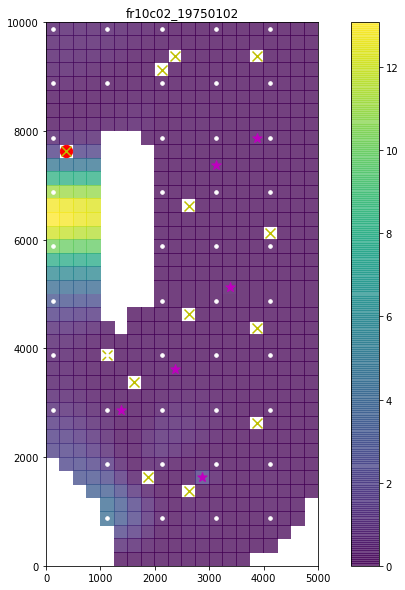

fr14c11_19750102


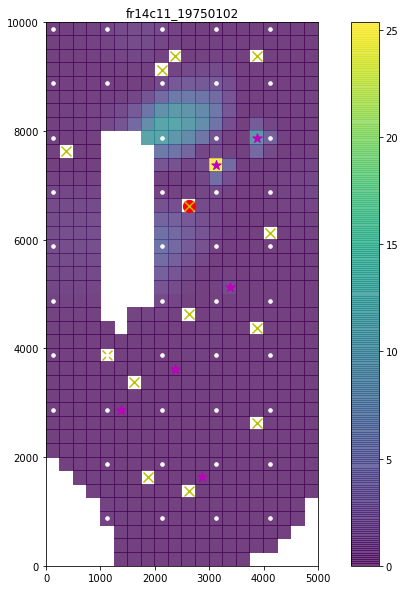

fr16c17_19750102


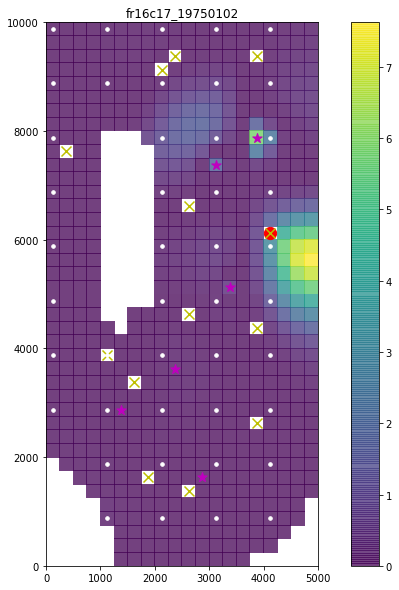

fr22c11_19750102


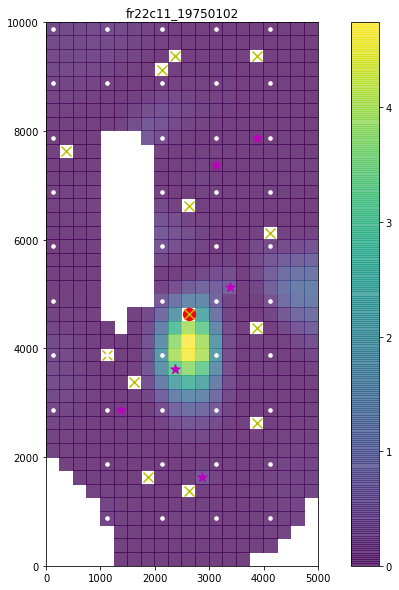

fr23c16_19750102


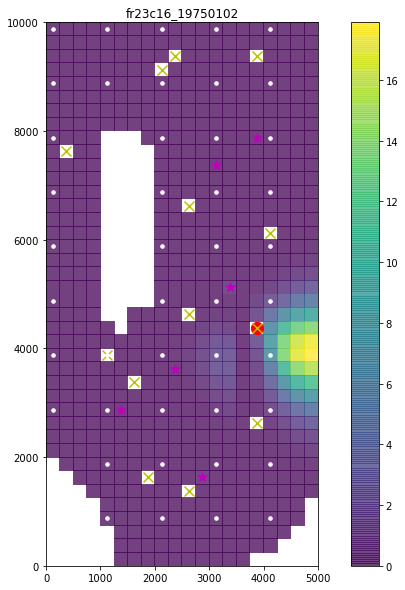

fr25c05_19750102


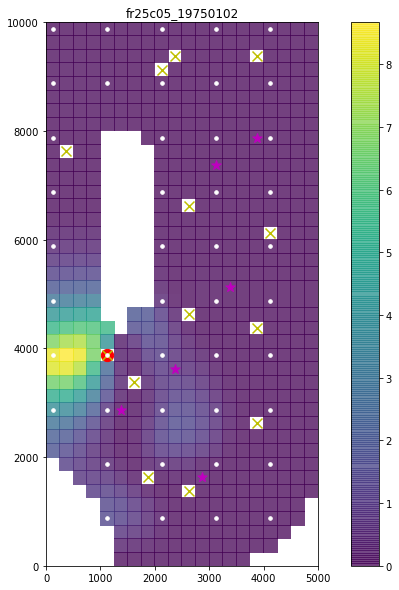

fr27c07_19750102


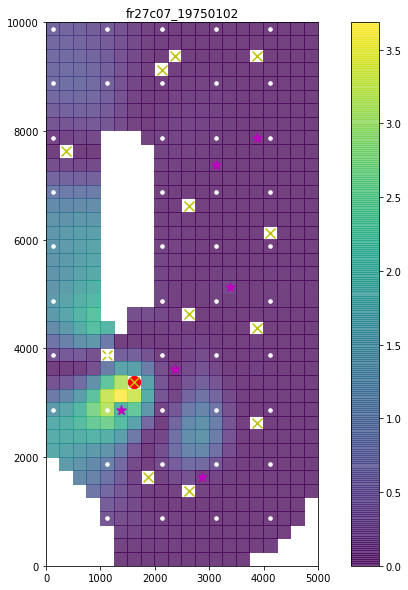

fr30c16_19750102


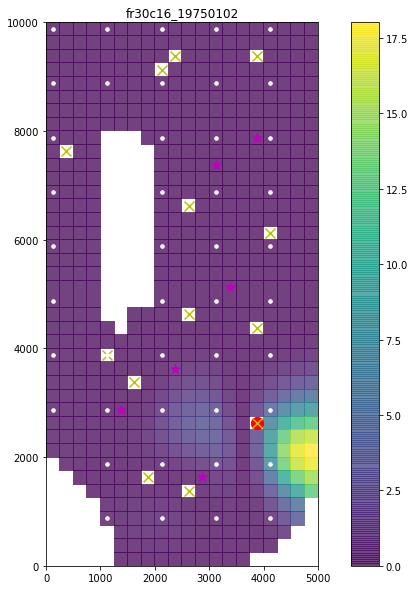

fr34c08_19750102


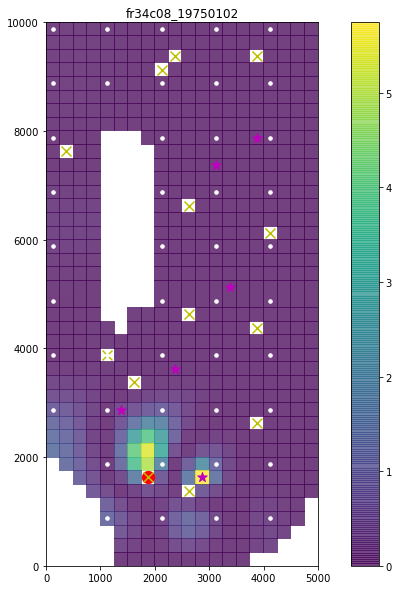

fr35c11_19750102


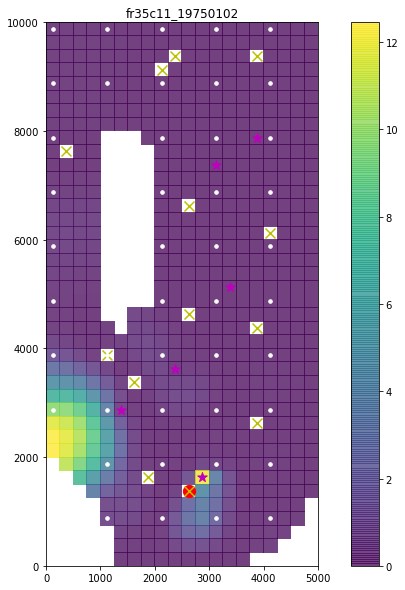

flx_river_l_19750102


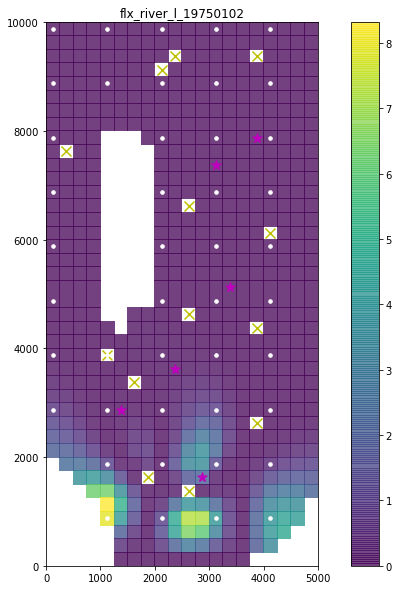

travel_time


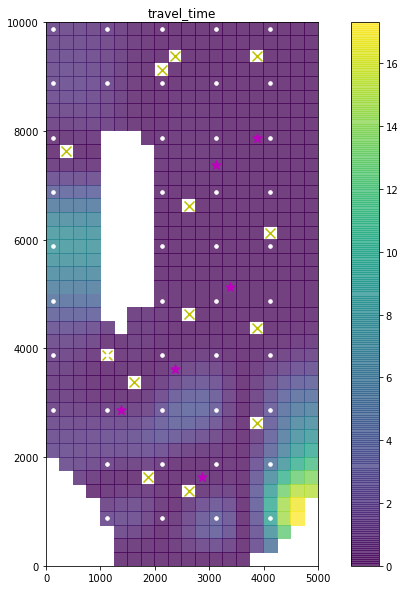

In [47]:
plot_added_worth(df_ad)

Ok, so those are cool.  And, unlike the zoned-parameterization dataworth, these make sense from a physical interpretation standpoint

Let's explore what happens when we use a full covariance prior

In [48]:
v = pyemu.geostats.ExpVario(contribution=1.0,a=2500.0)
gs = pyemu.geostats.GeoStruct(variograms=[v])
cov = pyemu.helpers.pilotpoint_prior_builder(sc.pst,
                            struct_dict={gs:os.path.join(working_dir,"hkpp.dat.tpl")})

/Users/jwhite/Dev/python/pyemu/pyemu/utils/helpers.py:55: UserWarning: 'pilotpoint_prior_builder' has been renamed to 'geostatistical_prior_builder'
  "'geostatistical_prior_builder'")


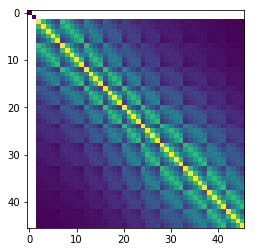

In [49]:
x = np.ma.masked_where(cov.x==0,cov.x)
plt.imshow(x)

In [50]:
sc_full = pyemu.Schur(jco=sc.jco,pst=sc.pst,parcov=cov,forecasts=sc.forecasts,verbose=True)

2017-09-09 17:34:15.820502 starting: pre-loading base components
2017-09-09 17:34:15.820878 starting: loading obscov
2017-09-09 17:34:16.022224 finished: loading obscov took: 0:00:00.201346
2017-09-09 17:34:16.022324 starting: loading forecasts
2017-09-09 17:34:16.029890 finished: loading forecasts took: 0:00:00.007566
2017-09-09 17:34:16.030004 forecast names: fr03c10_19750102,fr03c16_19750102,fr04c09_19750102,fr10c02_19750102,fr14c11_19750102,fr16c17_19750102,fr22c11_19750102,fr23c16_19750102,fr25c05_19750102,fr27c07_19750102,fr30c16_19750102,fr34c08_19750102,fr35c11_19750102,flx_river_l_19750102,travel_time
2017-09-09 17:34:16.030053 finished: pre-loading base components took: 0:00:00.209551
2017-09-09 17:34:16.030541 starting: dropping prior information
2017-09-09 17:34:16.031334 starting: removing 0 prior info from jco, pst, and obs cov
2017-09-09 17:34:16.033253 finished: removing 0 prior info from jco, pst, and obs cov took: 0:00:00.001919
2017-09-09 17:34:16.033324 finished: dr

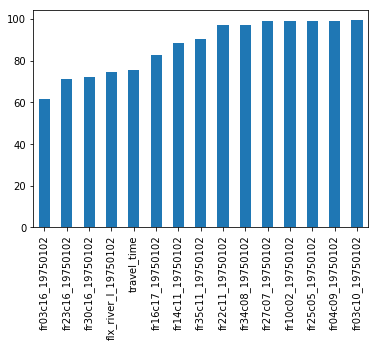

In [51]:
sc.get_forecast_summary().sort_values(by='percent_reduction').percent_reduction.plot(kind="bar")

In [52]:
df_full = sc_full.get_forecast_summary()
df_full.loc[:,"full"] = df_full.percent_reduction
df_full.loc[:,"diag"] = sc.get_forecast_summary().percent_reduction

2017-09-09 17:34:16.244087 starting: propagating prior to predictions
2017-09-09 17:34:16.244749 finished: propagating prior to predictions took: 0:00:00.000662
2017-09-09 17:34:16.244956 starting: propagating posterior to predictions
2017-09-09 17:34:16.245567 starting: Schur's complement
2017-09-09 17:34:16.246276 starting: xtqx
2017-09-09 17:34:17.456073 finished: xtqx took: 0:00:01.209797
2017-09-09 17:34:17.456776 finished: Schur's complement took: 0:00:01.211209
2017-09-09 17:34:17.457181 finished: propagating posterior to predictions took: 0:00:01.212225


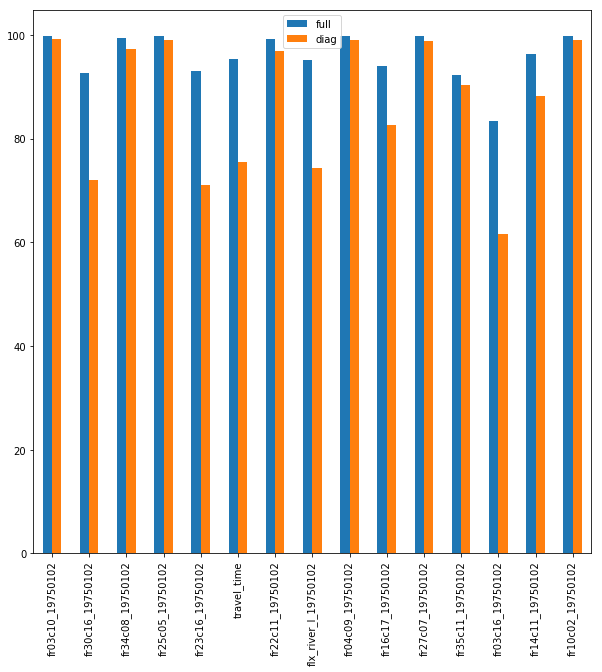

In [53]:
df_full.loc[:,["full","diag"]].plot(kind="bar",figsize=(10,10))

Why did percent reduction increase for all forecasts increase???

In [54]:
df_full.prior_var

fr03c10_19750102        8.917609e+00
fr30c16_19750102        1.525795e-01
fr34c08_19750102        4.212356e+00
fr25c05_19750102        1.671542e+01
fr23c16_19750102        1.362429e-01
travel_time             4.950501e+08
fr22c11_19750102        1.904255e+00
flx_river_l_19750102    1.482939e+04
fr04c09_19750102        1.131242e+01
fr16c17_19750102        2.630761e-01
fr27c07_19750102        1.040519e+01
fr35c11_19750102        3.317412e-01
fr03c16_19750102        5.941375e-02
fr14c11_19750102        7.154688e-01
fr10c02_19750102        2.688053e+01
Name: prior_var, dtype: float64

In [55]:
sc.get_forecast_summary().prior_var

fr03c10_19750102        2.375721e+00
fr30c16_19750102        5.011347e-02
fr34c08_19750102        1.108210e+00
fr25c05_19750102        3.131497e+00
fr23c16_19750102        4.679422e-02
travel_time             1.174574e+08
fr22c11_19750102        5.916668e-01
flx_river_l_19750102    5.313610e+03
fr04c09_19750102        2.808399e+00
fr16c17_19750102        1.102164e-01
fr27c07_19750102        2.113655e+00
fr35c11_19750102        3.171929e-01
fr03c16_19750102        3.555725e-02
fr14c11_19750102        2.957284e-01
fr10c02_19750102        4.454254e+00
Name: prior_var, dtype: float64

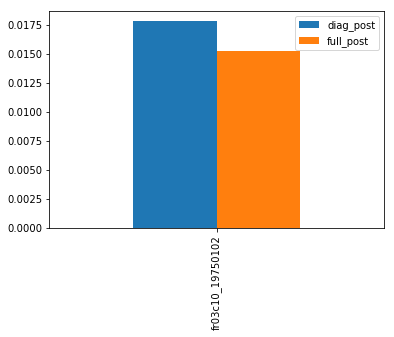

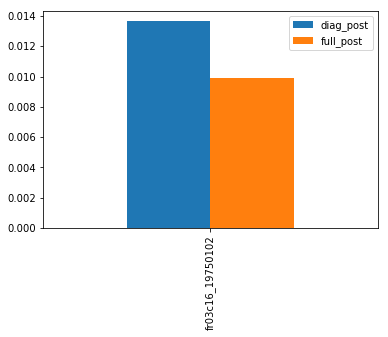

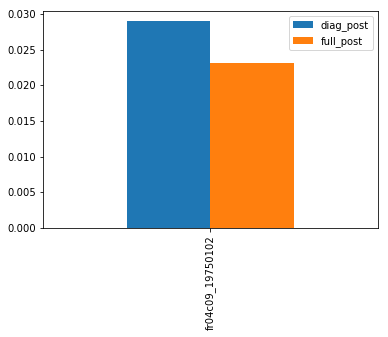

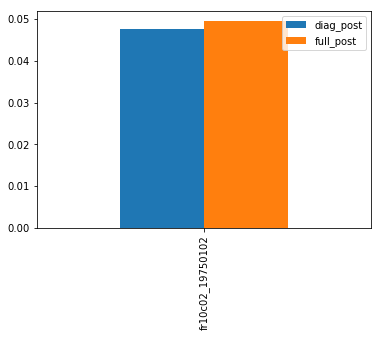

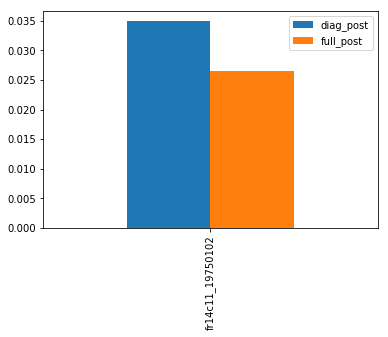

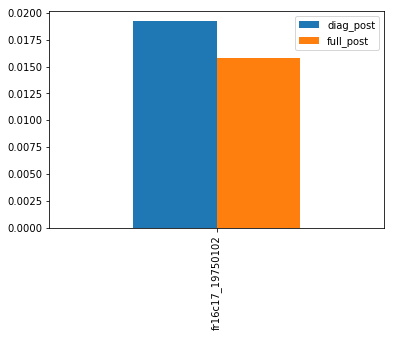

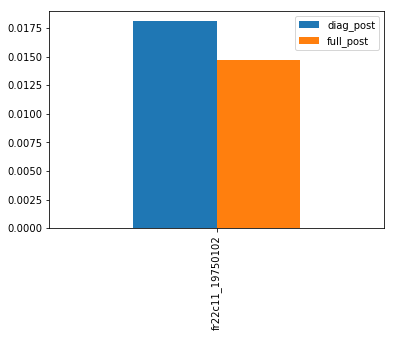

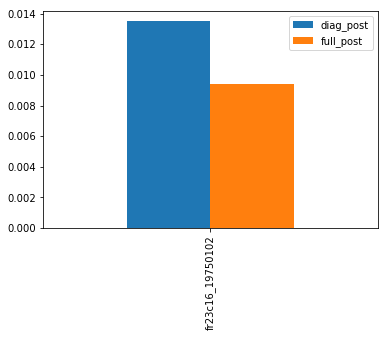

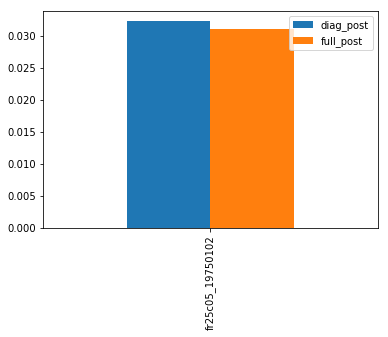

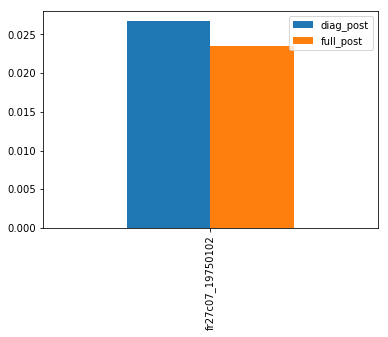

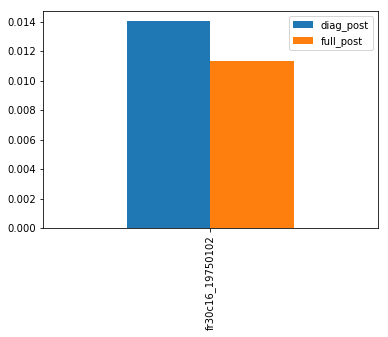

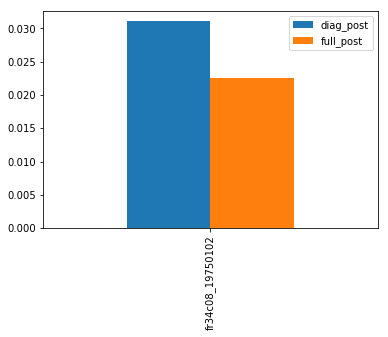

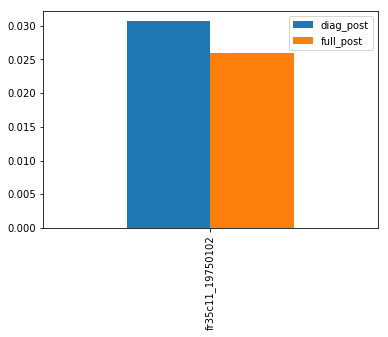

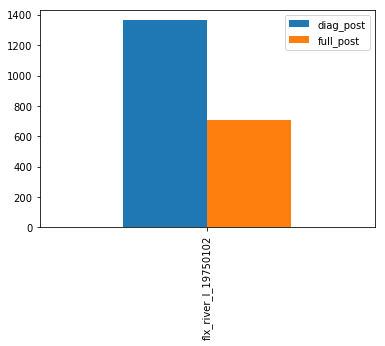

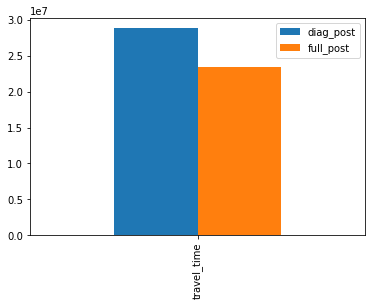

In [56]:
df_full.loc[:,"diag_post"] = sc.get_forecast_summary().post_var
df_full.loc[:,"full_post"] = df_full.post_var
for forecast in pst.forecast_names:
    df_full.loc[[forecast],["diag_post","full_post"]].plot(kind="bar")

Let's recalculate the value of possible new observations...this takes longer now that we are using a full covaraince matrix because the repeated matrix-matrix products...

In [57]:
df_full = sc_full.get_added_obs_importance(obslist_dict={oname:oname for oname in pobs_names},
                                base_obslist=sc.pst.nnz_obs_names,reset_zero_weight=True)

2017-09-09 17:34:20.051825 resetting zero weights to 1.0
2017-09-09 17:34:20.396027 starting: resetting zero weight obs in base_obslist
2017-09-09 17:34:20.408059 finished: resetting zero weight obs in base_obslist took: 0:00:00.012032
2017-09-09 17:34:20.408174 starting: resetting zero weight obs in pr12c15_19700102
2017-09-09 17:34:20.419850 finished: resetting zero weight obs in pr12c15_19700102 took: 0:00:00.011676
2017-09-09 17:34:20.419931 starting: resetting zero weight obs in pr12c02_19700102
2017-09-09 17:34:20.431684 finished: resetting zero weight obs in pr12c02_19700102 took: 0:00:00.011753
2017-09-09 17:34:20.431771 starting: resetting zero weight obs in pr17c15_19700102
2017-09-09 17:34:20.443544 finished: resetting zero weight obs in pr17c15_19700102 took: 0:00:00.011773
2017-09-09 17:34:20.443626 starting: resetting zero weight obs in pr02c05_19700102
2017-09-09 17:34:20.455608 finished: resetting zero weight obs in pr02c05_19700102 took: 0:00:00.011982
2017-09-09 17:34

2017-09-09 17:34:21.029833 finished: resetting zero weight obs in pr36c08_19700102 took: 0:00:00.015203
2017-09-09 17:34:21.030033 starting: resetting zero weight obs in pr02c08_19700102
2017-09-09 17:34:21.045783 finished: resetting zero weight obs in pr02c08_19700102 took: 0:00:00.015750
2017-09-09 17:34:21.045883 starting: resetting zero weight obs in pr31c07_19700102
2017-09-09 17:34:21.060624 finished: resetting zero weight obs in pr31c07_19700102 took: 0:00:00.014741
2017-09-09 17:34:21.060717 starting: resetting zero weight obs in pr02c20_19700102
2017-09-09 17:34:21.075802 finished: resetting zero weight obs in pr02c20_19700102 took: 0:00:00.015085
2017-09-09 17:34:21.075926 starting: resetting zero weight obs in pr19c09_19700102
2017-09-09 17:34:21.090651 finished: resetting zero weight obs in pr19c09_19700102 took: 0:00:00.014725
2017-09-09 17:34:21.090732 starting: resetting zero weight obs in pr10c03_19700102
2017-09-09 17:34:21.105482 finished: resetting zero weight obs in

2017-09-09 17:34:21.888695 finished: resetting zero weight obs in pr01c15_19700102 took: 0:00:00.016894
2017-09-09 17:34:21.888797 starting: resetting zero weight obs in pr07c17_19700102
2017-09-09 17:34:21.905466 finished: resetting zero weight obs in pr07c17_19700102 took: 0:00:00.016669
2017-09-09 17:34:21.905568 starting: resetting zero weight obs in pr20c03_19700102
2017-09-09 17:34:21.921820 finished: resetting zero weight obs in pr20c03_19700102 took: 0:00:00.016252
2017-09-09 17:34:21.921921 starting: resetting zero weight obs in pr34c17_19700102
2017-09-09 17:34:21.938316 finished: resetting zero weight obs in pr34c17_19700102 took: 0:00:00.016395
2017-09-09 17:34:21.938419 starting: resetting zero weight obs in pr40c10_19700102
2017-09-09 17:34:21.955118 finished: resetting zero weight obs in pr40c10_19700102 took: 0:00:00.016699
2017-09-09 17:34:21.955276 starting: resetting zero weight obs in pr30c11_19700102
2017-09-09 17:34:21.971596 finished: resetting zero weight obs in

2017-09-09 17:34:22.736829 starting: resetting zero weight obs in pr10c19_19700102
2017-09-09 17:34:22.753835 finished: resetting zero weight obs in pr10c19_19700102 took: 0:00:00.017006
2017-09-09 17:34:22.753988 starting: resetting zero weight obs in pr24c19_19700102
2017-09-09 17:34:22.771315 finished: resetting zero weight obs in pr24c19_19700102 took: 0:00:00.017327
2017-09-09 17:34:22.771415 starting: resetting zero weight obs in pr18c14_19700102
2017-09-09 17:34:22.788778 finished: resetting zero weight obs in pr18c14_19700102 took: 0:00:00.017363
2017-09-09 17:34:22.788888 starting: resetting zero weight obs in pr06c02_19700102
2017-09-09 17:34:22.805010 finished: resetting zero weight obs in pr06c02_19700102 took: 0:00:00.016122
2017-09-09 17:34:22.805085 starting: resetting zero weight obs in pr22c15_19700102
2017-09-09 17:34:22.820245 finished: resetting zero weight obs in pr22c15_19700102 took: 0:00:00.015160
2017-09-09 17:34:22.820317 starting: resetting zero weight obs in

2017-09-09 17:34:23.624213 finished: resetting zero weight obs in pr07c03_19700102 took: 0:00:00.016825
2017-09-09 17:34:23.624318 starting: resetting zero weight obs in pr16c13_19700102
2017-09-09 17:34:23.642046 finished: resetting zero weight obs in pr16c13_19700102 took: 0:00:00.017728
2017-09-09 17:34:23.642127 starting: resetting zero weight obs in pr15c03_19700102
2017-09-09 17:34:23.659291 finished: resetting zero weight obs in pr15c03_19700102 took: 0:00:00.017164
2017-09-09 17:34:23.659376 starting: resetting zero weight obs in pr40c08_19700102
2017-09-09 17:34:23.678367 finished: resetting zero weight obs in pr40c08_19700102 took: 0:00:00.018991
2017-09-09 17:34:23.678452 starting: resetting zero weight obs in pr27c17_19700102
2017-09-09 17:34:23.697964 finished: resetting zero weight obs in pr27c17_19700102 took: 0:00:00.019512
2017-09-09 17:34:23.698058 starting: resetting zero weight obs in pr09c17_19700102
2017-09-09 17:34:23.715487 finished: resetting zero weight obs in

2017-09-09 17:34:24.506694 finished: resetting zero weight obs in pr22c09_19700102 took: 0:00:00.018756
2017-09-09 17:34:24.506763 starting: resetting zero weight obs in pr11c02_19700102
2017-09-09 17:34:24.525638 finished: resetting zero weight obs in pr11c02_19700102 took: 0:00:00.018875
2017-09-09 17:34:24.525898 starting: resetting zero weight obs in pr33c16_19700102
2017-09-09 17:34:24.545847 finished: resetting zero weight obs in pr33c16_19700102 took: 0:00:00.019949
2017-09-09 17:34:24.545935 starting: resetting zero weight obs in pr21c10_19700102
2017-09-09 17:34:24.565742 finished: resetting zero weight obs in pr21c10_19700102 took: 0:00:00.019807
2017-09-09 17:34:24.565828 starting: resetting zero weight obs in pr16c01_19700102
2017-09-09 17:34:24.582667 finished: resetting zero weight obs in pr16c01_19700102 took: 0:00:00.016839
2017-09-09 17:34:24.582739 starting: resetting zero weight obs in pr06c08_19700102
2017-09-09 17:34:24.601703 finished: resetting zero weight obs in

2017-09-09 17:34:25.379496 starting: resetting zero weight obs in pr08c09_19700102
2017-09-09 17:34:25.400641 finished: resetting zero weight obs in pr08c09_19700102 took: 0:00:00.021145
2017-09-09 17:34:25.401051 starting: resetting zero weight obs in pr35c19_19700102
2017-09-09 17:34:25.420593 finished: resetting zero weight obs in pr35c19_19700102 took: 0:00:00.019542
2017-09-09 17:34:25.420728 starting: resetting zero weight obs in pr32c01_19700102
2017-09-09 17:34:25.440388 finished: resetting zero weight obs in pr32c01_19700102 took: 0:00:00.019660
2017-09-09 17:34:25.440507 starting: resetting zero weight obs in pr37c14_19700102
2017-09-09 17:34:25.459135 finished: resetting zero weight obs in pr37c14_19700102 took: 0:00:00.018628
2017-09-09 17:34:25.459224 starting: resetting zero weight obs in pr08c08_19700102
2017-09-09 17:34:25.477762 finished: resetting zero weight obs in pr08c08_19700102 took: 0:00:00.018538
2017-09-09 17:34:25.477860 starting: resetting zero weight obs in

2017-09-09 17:34:26.251724 starting: resetting zero weight obs in pr33c03_19700102
2017-09-09 17:34:26.271356 finished: resetting zero weight obs in pr33c03_19700102 took: 0:00:00.019632
2017-09-09 17:34:26.271532 starting: resetting zero weight obs in pr27c11_19700102
2017-09-09 17:34:26.292079 finished: resetting zero weight obs in pr27c11_19700102 took: 0:00:00.020547
2017-09-09 17:34:26.292177 starting: resetting zero weight obs in pr08c11_19700102
2017-09-09 17:34:26.310836 finished: resetting zero weight obs in pr08c11_19700102 took: 0:00:00.018659
2017-09-09 17:34:26.310922 starting: resetting zero weight obs in pr25c18_19700102
2017-09-09 17:34:26.328512 finished: resetting zero weight obs in pr25c18_19700102 took: 0:00:00.017590
2017-09-09 17:34:26.328589 starting: resetting zero weight obs in pr25c16_19700102
2017-09-09 17:34:26.349557 finished: resetting zero weight obs in pr25c16_19700102 took: 0:00:00.020968
2017-09-09 17:34:26.349665 starting: resetting zero weight obs in

2017-09-09 17:34:27.139008 finished: resetting zero weight obs in pr04c05_19700102 took: 0:00:00.020335
2017-09-09 17:34:27.139117 starting: resetting zero weight obs in pr14c02_19700102
2017-09-09 17:34:27.159691 finished: resetting zero weight obs in pr14c02_19700102 took: 0:00:00.020574
2017-09-09 17:34:27.159970 starting: resetting zero weight obs in pr05c13_19700102
2017-09-09 17:34:27.179082 finished: resetting zero weight obs in pr05c13_19700102 took: 0:00:00.019112
2017-09-09 17:34:27.179183 starting: resetting zero weight obs in pr25c08_19700102
2017-09-09 17:34:27.199388 finished: resetting zero weight obs in pr25c08_19700102 took: 0:00:00.020205
2017-09-09 17:34:27.199566 starting: resetting zero weight obs in pr22c13_19700102
2017-09-09 17:34:27.219757 finished: resetting zero weight obs in pr22c13_19700102 took: 0:00:00.020191
2017-09-09 17:34:27.219921 starting: resetting zero weight obs in pr35c07_19700102
2017-09-09 17:34:27.243194 finished: resetting zero weight obs in

2017-09-09 17:34:28.020600 finished: resetting zero weight obs in pr06c20_19700102 took: 0:00:00.018938
2017-09-09 17:34:28.020747 starting: resetting zero weight obs in pr14c17_19700102
2017-09-09 17:34:28.041580 finished: resetting zero weight obs in pr14c17_19700102 took: 0:00:00.020833
2017-09-09 17:34:28.041694 starting: resetting zero weight obs in pr11c10_19700102
2017-09-09 17:34:28.063240 finished: resetting zero weight obs in pr11c10_19700102 took: 0:00:00.021546
2017-09-09 17:34:28.063309 starting: resetting zero weight obs in pr36c14_19700102
2017-09-09 17:34:28.080933 finished: resetting zero weight obs in pr36c14_19700102 took: 0:00:00.017624
2017-09-09 17:34:28.081005 starting: resetting zero weight obs in pr18c13_19700102
2017-09-09 17:34:28.099036 finished: resetting zero weight obs in pr18c13_19700102 took: 0:00:00.018031
2017-09-09 17:34:28.099107 starting: resetting zero weight obs in pr12c13_19700102
2017-09-09 17:34:28.120467 finished: resetting zero weight obs in

2017-09-09 17:34:29.062594 starting: resetting zero weight obs in pr24c07_19700102
2017-09-09 17:34:29.082238 finished: resetting zero weight obs in pr24c07_19700102 took: 0:00:00.019644
2017-09-09 17:34:29.082341 starting: resetting zero weight obs in pr16c04_19700102
2017-09-09 17:34:29.105626 finished: resetting zero weight obs in pr16c04_19700102 took: 0:00:00.023285
2017-09-09 17:34:29.105734 starting: resetting zero weight obs in pr02c06_19700102
2017-09-09 17:34:29.128179 finished: resetting zero weight obs in pr02c06_19700102 took: 0:00:00.022445
2017-09-09 17:34:29.128268 starting: resetting zero weight obs in pr07c04_19700102
2017-09-09 17:34:29.152020 finished: resetting zero weight obs in pr07c04_19700102 took: 0:00:00.023752
2017-09-09 17:34:29.152088 starting: resetting zero weight obs in pr05c07_19700102
2017-09-09 17:34:29.171157 finished: resetting zero weight obs in pr05c07_19700102 took: 0:00:00.019069
2017-09-09 17:34:29.171232 starting: resetting zero weight obs in

2017-09-09 17:34:30.185017 finished: resetting zero weight obs in pr02c10_19700102 took: 0:00:00.022918
2017-09-09 17:34:30.185121 starting: resetting zero weight obs in pr18c17_19700102
2017-09-09 17:34:30.205835 finished: resetting zero weight obs in pr18c17_19700102 took: 0:00:00.020714
2017-09-09 17:34:30.205939 starting: resetting zero weight obs in pr26c16_19700102
2017-09-09 17:34:30.226203 finished: resetting zero weight obs in pr26c16_19700102 took: 0:00:00.020264
2017-09-09 17:34:30.226299 starting: resetting zero weight obs in pr31c17_19700102
2017-09-09 17:34:30.246354 finished: resetting zero weight obs in pr31c17_19700102 took: 0:00:00.020055
2017-09-09 17:34:30.246468 starting: resetting zero weight obs in pr03c01_19700102
2017-09-09 17:34:30.267263 finished: resetting zero weight obs in pr03c01_19700102 took: 0:00:00.020795
2017-09-09 17:34:30.267363 starting: resetting zero weight obs in pr11c11_19700102
2017-09-09 17:34:30.287080 finished: resetting zero weight obs in

2017-09-09 17:34:31.229042 starting: resetting zero weight obs in pr29c18_19700102
2017-09-09 17:34:31.251204 finished: resetting zero weight obs in pr29c18_19700102 took: 0:00:00.022162
2017-09-09 17:34:31.251710 starting: resetting zero weight obs in pr25c06_19700102
2017-09-09 17:34:31.273014 finished: resetting zero weight obs in pr25c06_19700102 took: 0:00:00.021304
2017-09-09 17:34:31.273124 starting: resetting zero weight obs in pr21c09_19700102
2017-09-09 17:34:31.294004 finished: resetting zero weight obs in pr21c09_19700102 took: 0:00:00.020880
2017-09-09 17:34:31.294107 starting: resetting zero weight obs in pr25c10_19700102
2017-09-09 17:34:31.314330 finished: resetting zero weight obs in pr25c10_19700102 took: 0:00:00.020223
2017-09-09 17:34:31.314427 starting: resetting zero weight obs in pr38c11_19700102
2017-09-09 17:34:31.336344 finished: resetting zero weight obs in pr38c11_19700102 took: 0:00:00.021917
2017-09-09 17:34:31.336441 starting: resetting zero weight obs in

2017-09-09 17:34:32.367397 finished: resetting zero weight obs in pr09c11_19700102 took: 0:00:00.021072
2017-09-09 17:34:32.367514 starting: resetting zero weight obs in pr36c19_19700102
2017-09-09 17:34:32.388467 finished: resetting zero weight obs in pr36c19_19700102 took: 0:00:00.020953
2017-09-09 17:34:32.388565 starting: resetting zero weight obs in pr05c05_19700102
2017-09-09 17:34:32.407870 finished: resetting zero weight obs in pr05c05_19700102 took: 0:00:00.019305
2017-09-09 17:34:32.407957 starting: resetting zero weight obs in pr09c12_19700102
2017-09-09 17:34:32.428397 finished: resetting zero weight obs in pr09c12_19700102 took: 0:00:00.020440
2017-09-09 17:34:32.428507 starting: resetting zero weight obs in pr32c18_19700102
2017-09-09 17:34:32.449071 finished: resetting zero weight obs in pr32c18_19700102 took: 0:00:00.020564
2017-09-09 17:34:32.449167 starting: resetting zero weight obs in pr22c08_19700102
2017-09-09 17:34:32.470213 finished: resetting zero weight obs in

2017-09-09 17:34:33.430703 finished: resetting self.obscov took: 0:00:00.000205
2017-09-09 17:34:33.431061 starting: loading obscov
2017-09-09 17:34:33.639847 finished: loading obscov took: 0:00:00.208786
2017-09-09 17:34:33.653683 starting: calculating importance of observations by adding: ['pr12c15_19700102']

2017-09-09 17:34:33.667547 finished: calculating importance of observations by adding: ['pr12c15_19700102']
 took: 0:00:00.013864
2017-09-09 17:34:33.667628 starting: calculating importance of observations by adding: ['pr12c02_19700102']

2017-09-09 17:34:33.684781 finished: calculating importance of observations by adding: ['pr12c02_19700102']
 took: 0:00:00.017153
2017-09-09 17:34:33.684877 starting: calculating importance of observations by adding: ['pr17c15_19700102']

2017-09-09 17:34:33.699621 finished: calculating importance of observations by adding: ['pr17c15_19700102']
 took: 0:00:00.014744
2017-09-09 17:34:33.699723 starting: calculating importance of observations by

2017-09-09 17:34:34.287832 finished: calculating importance of observations by adding: ['pr23c15_19700102']
 took: 0:00:00.014481
2017-09-09 17:34:34.287952 starting: calculating importance of observations by adding: ['pr34c11_19700102']

2017-09-09 17:34:34.302692 finished: calculating importance of observations by adding: ['pr34c11_19700102']
 took: 0:00:00.014740
2017-09-09 17:34:34.302787 starting: calculating importance of observations by adding: ['pr11c13_19700102']

2017-09-09 17:34:34.317127 finished: calculating importance of observations by adding: ['pr11c13_19700102']
 took: 0:00:00.014340
2017-09-09 17:34:34.317210 starting: calculating importance of observations by adding: ['pr07c15_19700102']

2017-09-09 17:34:34.331168 finished: calculating importance of observations by adding: ['pr07c15_19700102']
 took: 0:00:00.013958
2017-09-09 17:34:34.331239 starting: calculating importance of observations by adding: ['pr36c08_19700102']

2017-09-09 17:34:34.344784 finished: calcula

2017-09-09 17:34:34.927738 finished: calculating importance of observations by adding: ['pr01c08_19700102']
 took: 0:00:00.015422
2017-09-09 17:34:34.927915 starting: calculating importance of observations by adding: ['pr35c18_19700102']

2017-09-09 17:34:34.943324 finished: calculating importance of observations by adding: ['pr35c18_19700102']
 took: 0:00:00.015409
2017-09-09 17:34:34.943408 starting: calculating importance of observations by adding: ['pr13c01_19700102']

2017-09-09 17:34:34.957647 finished: calculating importance of observations by adding: ['pr13c01_19700102']
 took: 0:00:00.014239
2017-09-09 17:34:34.957710 starting: calculating importance of observations by adding: ['pr09c09_19700102']

2017-09-09 17:34:34.971865 finished: calculating importance of observations by adding: ['pr09c09_19700102']
 took: 0:00:00.014155
2017-09-09 17:34:34.971943 starting: calculating importance of observations by adding: ['pr34c04_19700102']

2017-09-09 17:34:34.985357 finished: calcula

2017-09-09 17:34:35.573719 finished: calculating importance of observations by adding: ['pr31c03_19700102']
 took: 0:00:00.015164
2017-09-09 17:34:35.573781 starting: calculating importance of observations by adding: ['pr22c04_19700102']

2017-09-09 17:34:35.588192 finished: calculating importance of observations by adding: ['pr22c04_19700102']
 took: 0:00:00.014411
2017-09-09 17:34:35.588263 starting: calculating importance of observations by adding: ['pr34c15_19700102']

2017-09-09 17:34:35.604672 finished: calculating importance of observations by adding: ['pr34c15_19700102']
 took: 0:00:00.016409
2017-09-09 17:34:35.604773 starting: calculating importance of observations by adding: ['pr29c09_19700102']

2017-09-09 17:34:35.618830 finished: calculating importance of observations by adding: ['pr29c09_19700102']
 took: 0:00:00.014057
2017-09-09 17:34:35.618897 starting: calculating importance of observations by adding: ['pr28c03_19700102']

2017-09-09 17:34:35.635314 finished: calcula

2017-09-09 17:34:36.232498 finished: calculating importance of observations by adding: ['pr29c06_19700102']
 took: 0:00:00.015212
2017-09-09 17:34:36.232581 starting: calculating importance of observations by adding: ['pr19c02_19700102']

2017-09-09 17:34:36.247986 finished: calculating importance of observations by adding: ['pr19c02_19700102']
 took: 0:00:00.015405
2017-09-09 17:34:36.248075 starting: calculating importance of observations by adding: ['pr31c15_19700102']

2017-09-09 17:34:36.262550 finished: calculating importance of observations by adding: ['pr31c15_19700102']
 took: 0:00:00.014475
2017-09-09 17:34:36.262636 starting: calculating importance of observations by adding: ['pr26c13_19700102']

2017-09-09 17:34:36.276634 finished: calculating importance of observations by adding: ['pr26c13_19700102']
 took: 0:00:00.013998
2017-09-09 17:34:36.276712 starting: calculating importance of observations by adding: ['pr24c12_19700102']

2017-09-09 17:34:36.290554 finished: calcula

2017-09-09 17:34:36.872042 finished: calculating importance of observations by adding: ['pr14c12_19700102']
 took: 0:00:00.014163
2017-09-09 17:34:36.872098 starting: calculating importance of observations by adding: ['pr25c02_19700102']

2017-09-09 17:34:36.886493 finished: calculating importance of observations by adding: ['pr25c02_19700102']
 took: 0:00:00.014395
2017-09-09 17:34:36.886569 starting: calculating importance of observations by adding: ['pr02c04_19700102']

2017-09-09 17:34:36.899295 finished: calculating importance of observations by adding: ['pr02c04_19700102']
 took: 0:00:00.012726
2017-09-09 17:34:36.899367 starting: calculating importance of observations by adding: ['pr32c20_19700102']

2017-09-09 17:34:36.915180 finished: calculating importance of observations by adding: ['pr32c20_19700102']
 took: 0:00:00.015813
2017-09-09 17:34:36.915248 starting: calculating importance of observations by adding: ['pr36c16_19700102']

2017-09-09 17:34:36.928279 finished: calcula

2017-09-09 17:34:37.527518 finished: calculating importance of observations by adding: ['pr04c03_19700102']
 took: 0:00:00.014888
2017-09-09 17:34:37.527587 starting: calculating importance of observations by adding: ['pr16c03_19700102']

2017-09-09 17:34:37.542774 finished: calculating importance of observations by adding: ['pr16c03_19700102']
 took: 0:00:00.015187
2017-09-09 17:34:37.542858 starting: calculating importance of observations by adding: ['pr29c12_19700102']

2017-09-09 17:34:37.557517 finished: calculating importance of observations by adding: ['pr29c12_19700102']
 took: 0:00:00.014659
2017-09-09 17:34:37.557627 starting: calculating importance of observations by adding: ['pr01c19_19700102']

2017-09-09 17:34:37.572867 finished: calculating importance of observations by adding: ['pr01c19_19700102']
 took: 0:00:00.015240
2017-09-09 17:34:37.572935 starting: calculating importance of observations by adding: ['pr28c08_19700102']

2017-09-09 17:34:37.587519 finished: calcula

2017-09-09 17:34:38.154592 starting: calculating importance of observations by adding: ['pr39c15_19700102']

2017-09-09 17:34:38.170120 finished: calculating importance of observations by adding: ['pr39c15_19700102']
 took: 0:00:00.015528
2017-09-09 17:34:38.170212 starting: calculating importance of observations by adding: ['pr12c11_19700102']

2017-09-09 17:34:38.183841 finished: calculating importance of observations by adding: ['pr12c11_19700102']
 took: 0:00:00.013629
2017-09-09 17:34:38.183931 starting: calculating importance of observations by adding: ['pr04c13_19700102']

2017-09-09 17:34:38.197572 finished: calculating importance of observations by adding: ['pr04c13_19700102']
 took: 0:00:00.013641
2017-09-09 17:34:38.197640 starting: calculating importance of observations by adding: ['pr29c10_19700102']

2017-09-09 17:34:38.210684 finished: calculating importance of observations by adding: ['pr29c10_19700102']
 took: 0:00:00.013044
2017-09-09 17:34:38.210741 starting: calcula

2017-09-09 17:34:38.804847 finished: calculating importance of observations by adding: ['pr09c02_19700102']
 took: 0:00:00.015137
2017-09-09 17:34:38.804927 starting: calculating importance of observations by adding: ['pr25c17_19700102']

2017-09-09 17:34:38.820523 finished: calculating importance of observations by adding: ['pr25c17_19700102']
 took: 0:00:00.015596
2017-09-09 17:34:38.820609 starting: calculating importance of observations by adding: ['pr14c09_19700102']

2017-09-09 17:34:38.835853 finished: calculating importance of observations by adding: ['pr14c09_19700102']
 took: 0:00:00.015244
2017-09-09 17:34:38.835932 starting: calculating importance of observations by adding: ['pr30c15_19700102']

2017-09-09 17:34:38.850321 finished: calculating importance of observations by adding: ['pr30c15_19700102']
 took: 0:00:00.014389
2017-09-09 17:34:38.850412 starting: calculating importance of observations by adding: ['pr22c01_19700102']

2017-09-09 17:34:38.865062 finished: calcula

2017-09-09 17:34:39.451733 finished: calculating importance of observations by adding: ['pr33c05_19700102']
 took: 0:00:00.013880
2017-09-09 17:34:39.451832 starting: calculating importance of observations by adding: ['pr06c12_19700102']

2017-09-09 17:34:39.466318 finished: calculating importance of observations by adding: ['pr06c12_19700102']
 took: 0:00:00.014486
2017-09-09 17:34:39.466392 starting: calculating importance of observations by adding: ['pr34c12_19700102']

2017-09-09 17:34:39.480692 finished: calculating importance of observations by adding: ['pr34c12_19700102']
 took: 0:00:00.014300
2017-09-09 17:34:39.480766 starting: calculating importance of observations by adding: ['pr01c07_19700102']

2017-09-09 17:34:39.494262 finished: calculating importance of observations by adding: ['pr01c07_19700102']
 took: 0:00:00.013496
2017-09-09 17:34:39.494325 starting: calculating importance of observations by adding: ['pr04c18_19700102']

2017-09-09 17:34:39.507118 finished: calcula

2017-09-09 17:34:40.108141 starting: calculating importance of observations by adding: ['pr26c03_19700102']

2017-09-09 17:34:40.122247 finished: calculating importance of observations by adding: ['pr26c03_19700102']
 took: 0:00:00.014106
2017-09-09 17:34:40.122312 starting: calculating importance of observations by adding: ['pr03c04_19700102']

2017-09-09 17:34:40.136164 finished: calculating importance of observations by adding: ['pr03c04_19700102']
 took: 0:00:00.013852
2017-09-09 17:34:40.136252 starting: calculating importance of observations by adding: ['pr13c20_19700102']

2017-09-09 17:34:40.150966 finished: calculating importance of observations by adding: ['pr13c20_19700102']
 took: 0:00:00.014714
2017-09-09 17:34:40.151053 starting: calculating importance of observations by adding: ['pr05c18_19700102']

2017-09-09 17:34:40.167480 finished: calculating importance of observations by adding: ['pr05c18_19700102']
 took: 0:00:00.016427
2017-09-09 17:34:40.167565 starting: calcula

2017-09-09 17:34:40.740529 finished: calculating importance of observations by adding: ['pr04c16_19700102']
 took: 0:00:00.013639
2017-09-09 17:34:40.740592 starting: calculating importance of observations by adding: ['pr23c14_19700102']

2017-09-09 17:34:40.754971 finished: calculating importance of observations by adding: ['pr23c14_19700102']
 took: 0:00:00.014379
2017-09-09 17:34:40.755049 starting: calculating importance of observations by adding: ['pr27c06_19700102']

2017-09-09 17:34:40.768250 finished: calculating importance of observations by adding: ['pr27c06_19700102']
 took: 0:00:00.013201
2017-09-09 17:34:40.768330 starting: calculating importance of observations by adding: ['pr26c14_19700102']

2017-09-09 17:34:40.783284 finished: calculating importance of observations by adding: ['pr26c14_19700102']
 took: 0:00:00.014954
2017-09-09 17:34:40.783361 starting: calculating importance of observations by adding: ['pr05c10_19700102']

2017-09-09 17:34:40.795873 finished: calcula

2017-09-09 17:34:41.394594 finished: calculating importance of observations by adding: ['pr05c08_19700102']
 took: 0:00:00.015209
2017-09-09 17:34:41.394688 starting: calculating importance of observations by adding: ['pr35c04_19700102']

2017-09-09 17:34:41.409878 finished: calculating importance of observations by adding: ['pr35c04_19700102']
 took: 0:00:00.015190
2017-09-09 17:34:41.409954 starting: calculating importance of observations by adding: ['pr19c17_19700102']

2017-09-09 17:34:41.424204 finished: calculating importance of observations by adding: ['pr19c17_19700102']
 took: 0:00:00.014250
2017-09-09 17:34:41.424289 starting: calculating importance of observations by adding: ['pr23c03_19700102']

2017-09-09 17:34:41.438781 finished: calculating importance of observations by adding: ['pr23c03_19700102']
 took: 0:00:00.014492
2017-09-09 17:34:41.438863 starting: calculating importance of observations by adding: ['pr08c20_19700102']

2017-09-09 17:34:41.452670 finished: calcula

2017-09-09 17:34:42.010277 starting: calculating importance of observations by adding: ['pr12c16_19700102']

2017-09-09 17:34:42.024679 finished: calculating importance of observations by adding: ['pr12c16_19700102']
 took: 0:00:00.014402
2017-09-09 17:34:42.024745 starting: calculating importance of observations by adding: ['pr29c18_19700102']

2017-09-09 17:34:42.040365 finished: calculating importance of observations by adding: ['pr29c18_19700102']
 took: 0:00:00.015620
2017-09-09 17:34:42.040438 starting: calculating importance of observations by adding: ['pr25c06_19700102']

2017-09-09 17:34:42.054537 finished: calculating importance of observations by adding: ['pr25c06_19700102']
 took: 0:00:00.014099
2017-09-09 17:34:42.054632 starting: calculating importance of observations by adding: ['pr21c09_19700102']

2017-09-09 17:34:42.069340 finished: calculating importance of observations by adding: ['pr21c09_19700102']
 took: 0:00:00.014708
2017-09-09 17:34:42.069425 starting: calcula

2017-09-09 17:34:42.681936 finished: calculating importance of observations by adding: ['pr01c09_19700102']
 took: 0:00:00.014753
2017-09-09 17:34:42.682134 starting: calculating importance of observations by adding: ['pr36c09_19700102']

2017-09-09 17:34:42.697415 finished: calculating importance of observations by adding: ['pr36c09_19700102']
 took: 0:00:00.015281
2017-09-09 17:34:42.697484 starting: calculating importance of observations by adding: ['pr20c02_19700102']

2017-09-09 17:34:42.711920 finished: calculating importance of observations by adding: ['pr20c02_19700102']
 took: 0:00:00.014436
2017-09-09 17:34:42.712025 starting: calculating importance of observations by adding: ['pr29c19_19700102']

2017-09-09 17:34:42.726314 finished: calculating importance of observations by adding: ['pr29c19_19700102']
 took: 0:00:00.014289
2017-09-09 17:34:42.726400 starting: calculating importance of observations by adding: ['pr14c20_19700102']

2017-09-09 17:34:42.740344 finished: calcula

2017-09-09 17:34:43.320969 finished: calculating importance of observations by adding: ['pr20c20_19700102']
 took: 0:00:00.015699
2017-09-09 17:34:43.321140 starting: calculating importance of observations by adding: ['pr36c07_19700102']

2017-09-09 17:34:43.335737 finished: calculating importance of observations by adding: ['pr36c07_19700102']
 took: 0:00:00.014597
2017-09-09 17:34:43.335826 starting: calculating importance of observations by adding: ['pr17c12_19700102']

2017-09-09 17:34:43.350528 finished: calculating importance of observations by adding: ['pr17c12_19700102']
 took: 0:00:00.014702
2017-09-09 17:34:43.350628 starting: calculating importance of observations by adding: ['pr25c03_19700102']

2017-09-09 17:34:43.364788 finished: calculating importance of observations by adding: ['pr25c03_19700102']
 took: 0:00:00.014160
2017-09-09 17:34:43.364850 starting: calculating importance of observations by adding: ['pr25c09_19700102']

2017-09-09 17:34:43.379535 finished: calcula

fr03c10_19750102


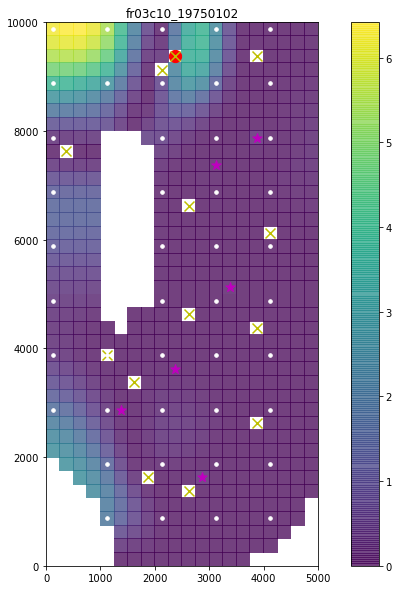

fr03c16_19750102


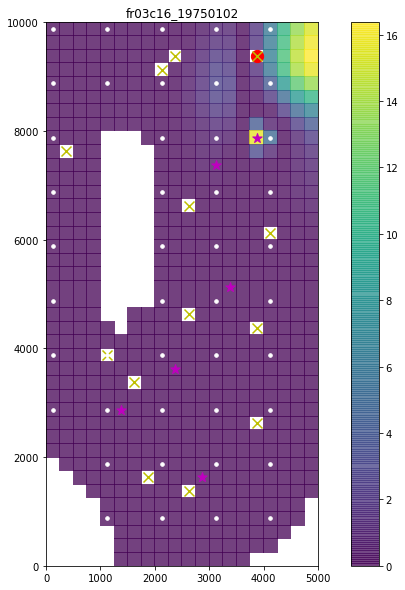

fr04c09_19750102


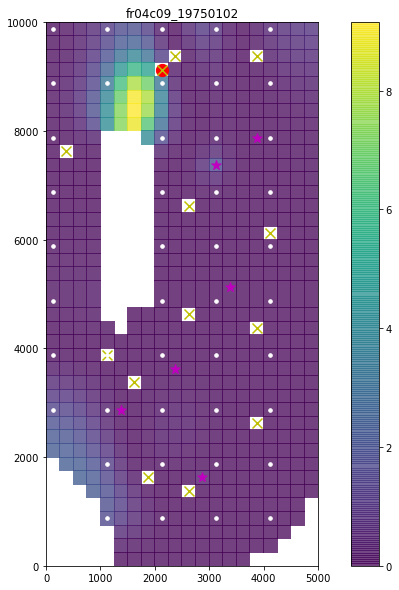

fr10c02_19750102


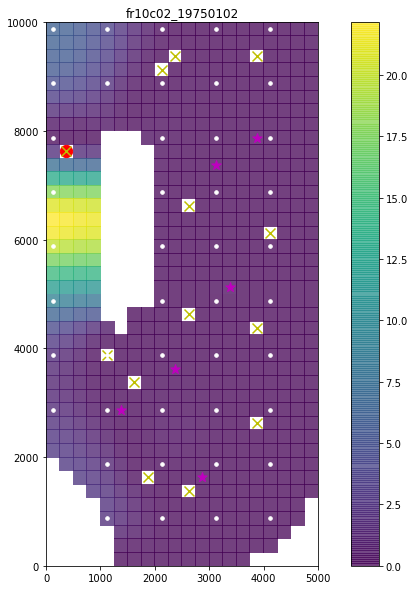

fr14c11_19750102


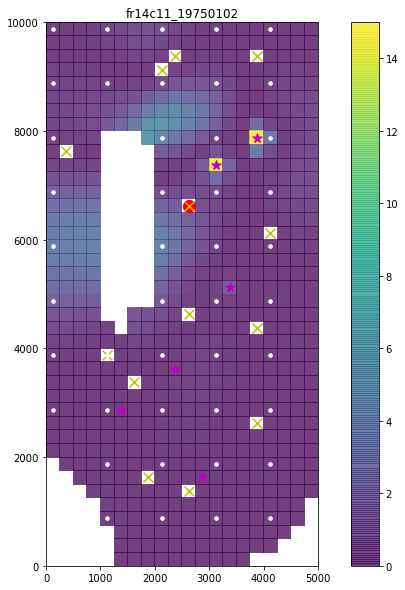

fr16c17_19750102


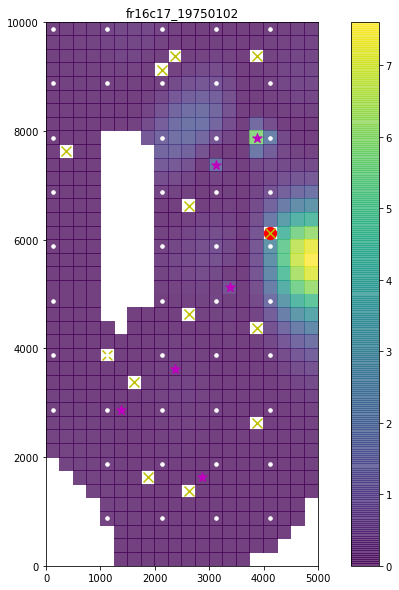

fr22c11_19750102


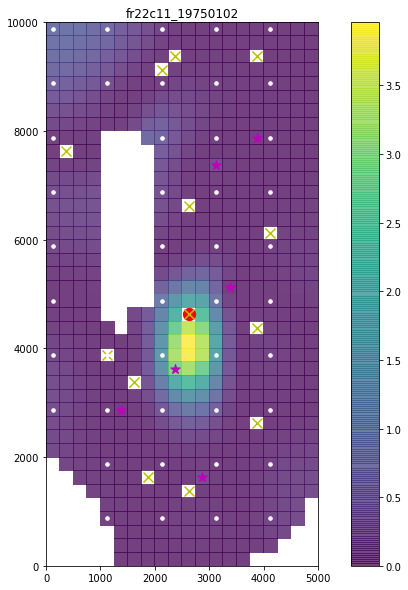

fr23c16_19750102


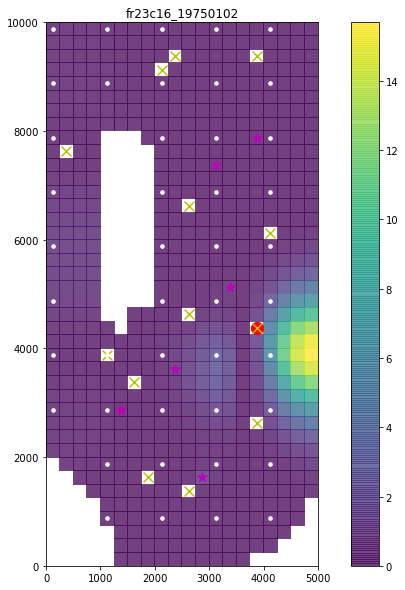

fr25c05_19750102


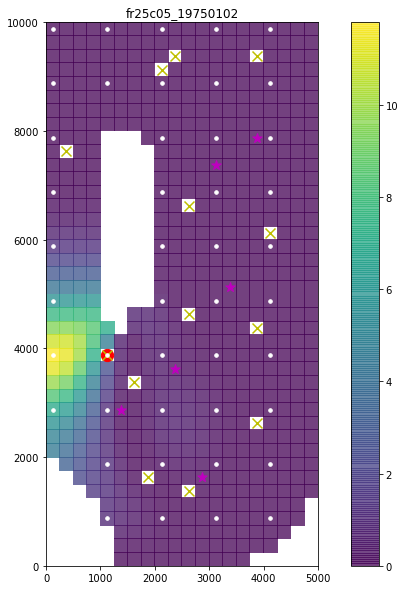

fr27c07_19750102


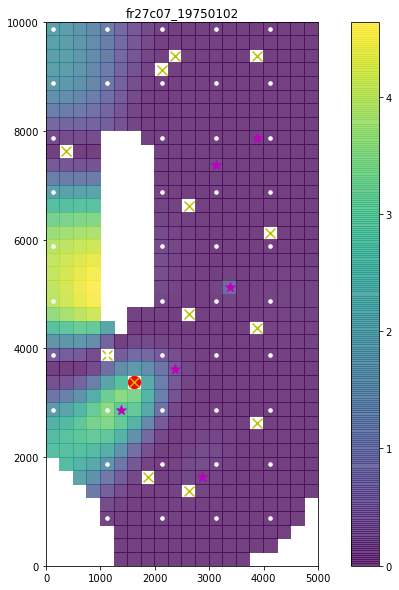

fr30c16_19750102


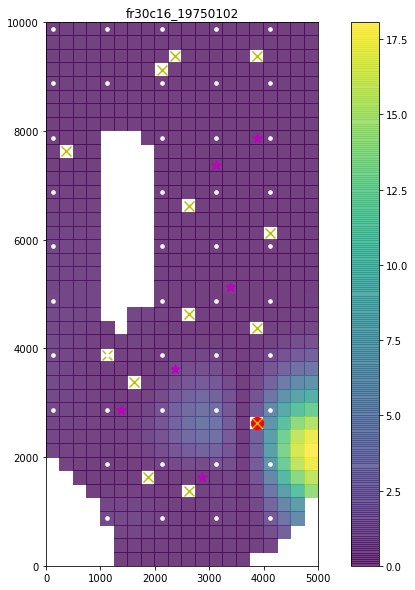

fr34c08_19750102


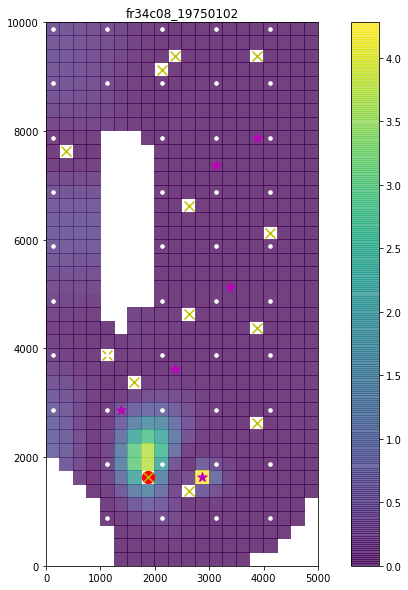

fr35c11_19750102


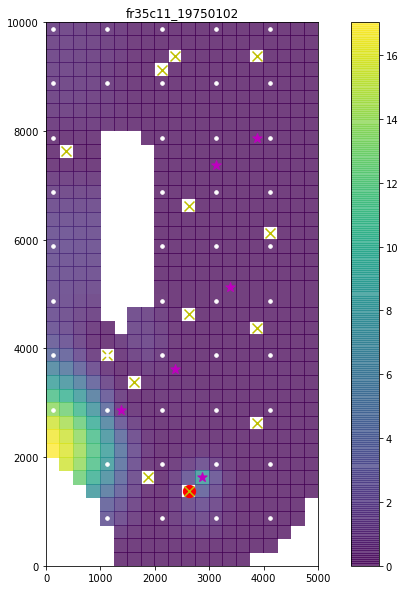

flx_river_l_19750102


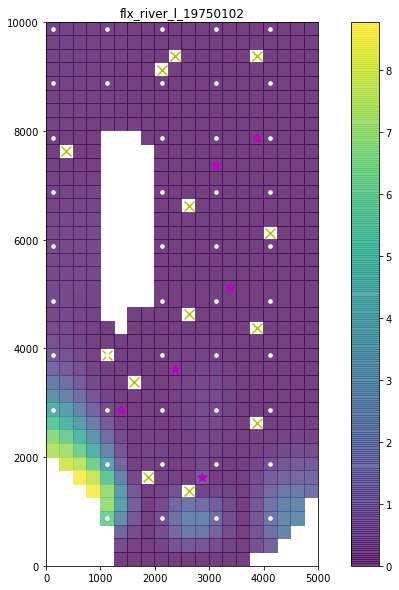

travel_time


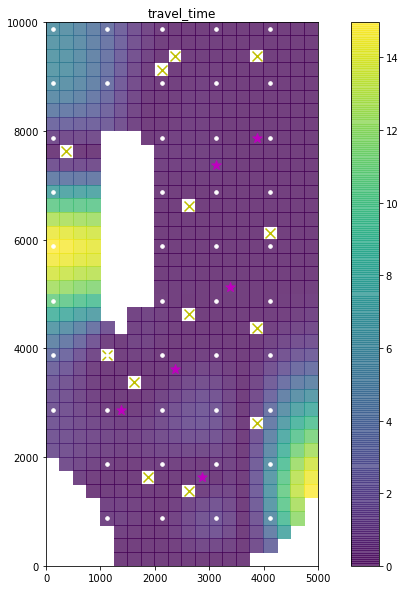

In [58]:
plot_added_worth(df_full)

In [59]:
df = sc.forecasts.to_dataframe()

In [60]:
df.loc[:,"travel_time"]

rch_0       0.000000
rch_1      -4.628158
hk00      -20.826710
hk01      259.176840
hk02      418.848286
hk03      286.945787
hk04       18.512631
hk05      323.971050
hk06     1335.223540
hk07     1124.642358
hk08      520.667758
hk09       64.794210
hk10      728.934862
hk11     1050.591832
hk12      252.234603
hk13       -2.314079
hk14     -138.844736
hk15      -41.653421
hk16      101.819473
hk17      -20.826710
hk18     -907.118939
hk19     -455.873548
hk20      192.068551
hk21       30.083026
hk22    -1527.292091
hk23     -393.393417
hk24     1120.014200
hk25      349.425918
hk26     -404.963812
hk27    -3140.205102
hk28    -2679.703396
hk29    -1536.548407
hk30     -740.505256
hk31       78.678683
hk32      289.259866
hk33      398.021575
hk34    -9341.936623
hk35    -6400.742308
hk36      159.671446
hk37      298.516181
hk38    -8541.265314
hk39    -7400.424404
hk40     -326.285129
hk41     -398.021575
hk42    -9682.106225
hk43    -9432.185701
Name: travel_time, dtype: float64

In [61]:
jco = sc.jco.to_dataframe()

In [67]:
s = jco.loc[[n for n in sc.pst.obs_names if n.startswith("p")],"hk42"]
s.sort_values(inplace=True)
s

pr37c11_19700102   -1.709668
pr36c11_19700102   -1.660896
pr37c10_19700102   -1.659572
pr36c10_19700102   -1.651627
pr37c12_19700102   -1.502663
pr35c10_19700102   -1.462277
pr36c09_19700102   -1.426084
pr38c11_19700102   -1.405560
pr37c09_19700102   -1.402691
pr36c12_19700102   -1.378416
pr38c10_19700102   -1.375768
pr35c09_19700102   -1.321920
pr38c12_19700102   -1.206279
pr34c10_19700102   -1.199659
pr38c09_19700102   -1.185976
pr36c08_19700102   -1.154197
pr34c09_19700102   -1.128597
pr37c11_19750101   -1.126832
pr37c11_19750102   -1.125287
pr37c10_19750101   -1.124625
pr37c10_19750102   -1.123080
pr37c08_19700102   -1.120211
pr35c08_19700102   -1.092404
pr36c10_19750101   -1.079605
pr36c10_19750102   -1.078060
pr34c11_19700102   -1.023329
pr36c11_19750101   -1.006116
pr36c11_19750102   -1.004571
pr37c13_19700102   -0.984488
pr38c11_19750101   -0.969481
                      ...   
pr16c15_19700102    0.000000
pr16c15_19700101    0.000000
pr16c14_19700101    0.000000
pr16c13_197001